In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
# disentangled vae
sys.path.append('../disentangling-vae')
from collections import defaultdict
import vae_trim, vae_trim_viz
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import get_loss_f
from utils.datasets import get_dataloaders, DSprites

### Train model

In [2]:
args = vae_trim.parse_arguments()
args.attr_lamb = 0
name = args.loss + "_" + str(args.attr_lamb)
args.name = name

In [3]:
dataset = DSprites()

In [4]:
dsprites = np.load('../disentangling-vae/data/dsprites/dsprite_train.npz')
imgs = dsprites['imgs']
latents_values = dsprites['latents_values']

In [ ]:
0., 0.03225806, 0.06451613, 0.09677419,
0.12903226, 0.16129032, 0.19354839, 0.22580645, 
    
0.25806452,0.29032258, 0.32258065, 0.35483871, 
0.38709677, 0.41935484, 0.4516129, 0.48387097, 

0.51612903, 0.5483871, 0.58064516, 0.61290323, 
0.64516129, 0.67741935, 0.70967742, 0.74193548, 

0.77419355, 0.80645161, 0.83870968, 0.87096774, 
0.90322581,0.93548387, 0.96774194, 1.]),

In [5]:
x_pos = latents_values[:,4]
y_pos = latents_values[:,5]
idx1 = np.logical_and(x_pos>=0, x_pos<=0.1)
idx2 = np.logical_and(y_pos>=0, y_pos<=0.1)
idx = np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.11, x_pos<=0.23)
idx2 = np.logical_and(y_pos>=0.11, y_pos<=0.23)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.24, x_pos<=0.36)
idx2 = np.logical_and(y_pos>=0.24, y_pos<=0.36)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.37, x_pos<=0.49)
idx2 = np.logical_and(y_pos>=0.37, y_pos<=0.49)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.50, x_pos<=0.62)
idx2 = np.logical_and(y_pos>=0.50, y_pos<=0.62)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.63, x_pos<=0.75)
idx2 = np.logical_and(y_pos>=0.63, y_pos<=0.75)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.76, x_pos<=0.88)
idx2 = np.logical_and(y_pos>=0.76, y_pos<=0.88)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.9, x_pos<=1.0)
idx2 = np.logical_and(y_pos>=0.9, y_pos<=1.0)
idx = idx + np.logical_and(idx1, idx2)
print(idx.sum())

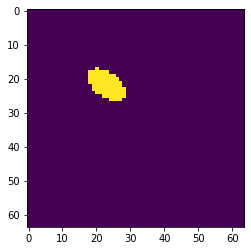

In [20]:
plt.imshow(imgs[idx,:][35230])

In [99]:
x_pos = latents_values[:,4]
y_pos = latents_values[:,5]
idx1 = np.logical_and(x_pos>=0, x_pos<=0.23)
idx2 = np.logical_and(y_pos>=0, y_pos<=0.23)
idx = np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.25, x_pos<=0.49)
idx2 = np.logical_and(y_pos>=0.25, y_pos<=0.49)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.51, x_pos<=0.75)
idx2 = np.logical_and(y_pos>=0.51, y_pos<=0.75)
idx = idx + np.logical_and(idx1, idx2)
idx1 = np.logical_and(x_pos>=0.77, x_pos<=1.0)
idx2 = np.logical_and(y_pos>=0.77, y_pos<=1.0)
idx = idx + np.logical_and(idx1, idx2)
print(idx.sum())

[autoreload of utils.datasets failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


In [100]:
print(idx.sum())

184320


In [92]:
x_pos = latents_values[:,4]
y_pos = latents_values[:,5]
idx1 = np.logical_and(x_pos>=0, x_pos<=0.1)
idx2 = np.logical_and(y_pos>=0, y_pos<=0.1)
idx = np.logical_and(idx1, idx2)

In [91]:
idx.sum()

23040

In [88]:
idx.sum()

18000

In [84]:
x_pos.shape

(737280,)

In [57]:
slack = 0.07
idx = np.logical_and(latents_values[:,5] <= latents_values[:,4] + slack, latents_values[:,5] >= latents_values[:,4] - slack)
imgs0 = imgs[idx,:]
latents_values0 = latents_values[idx,:]

In [62]:
get_dataloaders

<function utils.datasets.get_dataloaders(dataset, root=None, shuffle=True, pin_memory=True, batch_size=128, logger=<Logger utils.datasets (WARNING)>, **kwargs)>

In [78]:
data_loader = get_dataloaders(args.dataset, batch_size=args.batch_size)

In [79]:
data_loader.dataset.imgs.shape

(110880, 64, 64)